# Roller Coaster
![Millennium Force](millennium_force.jpg)

This is a project from the Codecademy Data Science Carrer Path.
The data supplied for this project is located in `Golden_Ticket_Award_Winners_Steel.csv`, `Golden_Ticket_Award_Winners_Wood.csv`, and `roller_coasters.csv`.

The Golden Ticket Awards are presented by *Amusement Today*, a trade pulication of the amusement industry.

First, I will start by exploring the Golden Ticket Award datasets.

In [291]:
import pandas as pd
import matplotlib.pyplot as plt

steel_awards = pd.read_csv('Golden_Ticket_Award_Winners_Steel.csv')
wooden_awards = pd.read_csv('Golden_Ticket_Award_Winners_Wood.csv')
steel_awards

,Rank,Name,Park,Location,Supplier,Year Built,Points,Year of Rank
0,1,Millennium Force,Cedar Point,"Sandusky, Ohio",Intamin,2000,1204,2013
1,2,Bizarro,Six Flags New England,"Agawam, Mass.",Intamin,2000,1011,2013
2,3,Expedition GeForce,Holiday Park,"Hassloch, Germany",Intamin,2001,598,2013
3,4,Nitro,Six Flags Great Adventure,"Jackson, N.J.",B&M,2001,596,2013
4,5,Apollo’s Chariot,Busch Gardens Williamsburg,"Williamsburg, Va.",B&M,1999,542,2013
...,...,...,...,...,...,...,...,...
175,46,Expedition Everest,Disney’s Animal Kingdom,"Orlando, Fla.",Vekoma,2006,82,2018
176,47,Storm Chaser,Kentucky Kingdom,"Louisville, Ky.",Rocky Mountain,2016,81,2018
177,48,Raging Bull,Six Flags Great America,"Gurnee, Ill.",B&M,1999,78,2018
178,49,Thunderbird,Holiday World,"Santa Claus, Ind.",B&M,2015,72,2018


Some of the parks have apostrophies that are not the same as `'`, so I will try to clean these up by simply removing them all.
Further, in my exploration, I discovered that "Canada's Wonderland" was listed with two different locations at different points in the dataset. Sometimes it's location was "Vaughan, Ontario, Canada", and others it was "Vaughan, Ont., Canada". Since these are clearly the same, I will make them all match.

In [292]:
steel_awards["Park"] = steel_awards["Park"].replace("`|’|'", "", regex=True)
steel_awards.loc[steel_awards.loc[:, "Park"] == "Canadas Wonderland", "Location"] = "Vaughan, Ontario, Canada"

Now to explore the `wooden_awards` dataset.

In [293]:
wooden_awards

,Rank,Name,Park,Location,Supplier,Year Built,Points,Year of Rank
0,1,Boulder Dash,Lake Compounce,"Bristol, Conn.",CCI,2000,1333,2013
1,2,El Toro,Six Flags Great Adventure,"Jackson, N.J.",Intamin,2006,1302,2013
2,3,Phoenix,Knoebels Amusement Resort,"Elysburg, Pa.",Dinn/PTC-Schmeck,1985,1088,2013
3,4,The Voyage,Holiday World,"Santa Claus, Ind.",Gravity Group,2006,1086,2013
4,5,Thunderhead,Dollywood,"Pigeon Forge, Tenn.",GCII,2004,923,2013
...,...,...,...,...,...,...,...,...
175,46,Megafobia,Oakwood,"Pembrookshire, Wales",Custom Coasters,1996,84,2018
176,47,Hades 360,Mount Olympus,"Wisconsin Dells, Wis.",Gravity Group,2005,80,2018
177,48,Mine Blower,Fun Spot,"Kissimmee, Fla.",Gravity Group,2017,79,2018
178,49,Wooden Warrior,Quassy Amusement Park,"Meddlebury, Conn.",Gravity Group,2011,77,2018


I can perform some exploratory data analysis on these datasets by:
    * Which parks have the most rides appearing in the awards lists?
    * Which suppliers have built the most awarded coasters?
 

The following two code blocks display the 10 parks with the greatest number of unique roller coasters appearing at any time on the awards lists.

In [294]:
parks_with_awarded_rides_steel = steel_awards[["Name", "Park", "Location"]].drop_duplicates().groupby(["Park", "Location"]).count().sort_values("Name", ascending = False).rename(columns = {"Name":"Count"}).reset_index()
parks_with_awarded_rides_steel.head(10)

,Park,Location,Count
0,Cedar Point,"Sandusky, Ohio",7
1,Busch Gardens Williamsburg,"Williamsburg, Va.",4
2,Six Flags New England,"Agawam, Mass.",4
3,Six Flags Magic Mountain,"Valencia, Calif.",3
4,Busch Gardens Tampa,"Tampa, Fla.",3
5,Kings Dominion,"Doswell, Va.",3
6,Six Flags Great America,"Gurnee, Ill.",2
7,Liseberg,"Gothenburg, Sweden",2
8,Kings Island,"Mason, Ohio",2
9,Kentucky Kingdom,"Louisville, Ky.",2


It would be nice to be able to visulaize these. I could create a bar plot where the height of the bar correlated to how many awarded coasters each park has, but this would have quite a few parks on the horizontal axis, most with 1 coaster each. 

Instead, it would be nicer to be able to see these parks laid out on a map with this information embedded!  I will attempt to plot the park locations on a world map with bubbles, where the size of the bubble is correlated to how many awarded coasters that park has!

Unfortunately, this dataset does not come with longitude and latituded coordinates already. To solve this, I will utilize the `requests` and `urllib.parse` packages. Since one of the columns we have is the location (in string form) of the park, we can supply these to our search.

Since all searches may not be successful, I will employ `try:` and `except:` statements. If the `except` condition is met, I will keep the coordinates as 0.0, 0.0. Since this is in the middle of the Atlantic Ocean, I will be able to quickly identify the unlabeled parks and manually correct their position in the dataset. 

In [295]:
import numpy as np
import requests
import urllib.parse
steel_lat_lon = np.zeros([parks_with_awarded_rides_steel.shape[0], 2])
for row in range(0, parks_with_awarded_rides_steel.shape[0]):
    address = parks_with_awarded_rides_steel["Location"][row]
    url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'
    response = requests.get(url).json()
    try:
        steel_lat_lon[row][0] = response[0]["lat"]
        steel_lat_lon[row][1] = response[0]["lon"]
    except IndexError:
        pass

Now I will add these latitude and longitude coordinates to the steel coaster dataframe and use `folium` to plot their location on a world map.

Each location can be clicked on to see the name of the park and the number of awarded coasters is has.

In [296]:
import folium
steel_lat_lon_df = pd.DataFrame(steel_lat_lon, columns = ['Lat', 'Lon'])
parks_steel_locations = parks_with_awarded_rides_steel.join(steel_lat_lon_df)

lon_mean = parks_steel_locations["Lon"].mean()
lat_mean = parks_steel_locations["Lat"].mean()
m = folium.Map(location=[lat_mean, lon_mean], zoom_start=1)

for i in range(0,len(parks_steel_locations)):
    folium.Circle(
        location=[parks_steel_locations.iloc[i]['Lat'], parks_steel_locations.iloc[i]['Lon']],
        popup=str(parks_steel_locations.iloc[i]['Park']) + "\n\nNum awarded steel coasters: " + str(parks_steel_locations.iloc[i]['Count']),
        radius=float((parks_steel_locations.iloc[i]['Count']*100)**2),
        color='crimson',
        fill=True,
        fill_color='crimson').add_to(m)
m.save('awarded_steel_coasters_map.html')
m

From the map, you can see the few parks that were not correctly located as they are placed in the middle of the Atlantic at (0.00, 0.00). I can go through these and manually provide the proper coordinates.

In [297]:
parks_steel_locations.loc[parks_steel_locations.loc[:, "Park"] == "Six Flags Great America", "Lat"] = 42.370377
parks_steel_locations.loc[parks_steel_locations.loc[:, "Park"] == "Six Flags Great America", "Lon"] = -87.936487

parks_steel_locations.loc[parks_steel_locations.loc[:, "Park"] == "Six Flags America", "Lat"] = 38.907599
parks_steel_locations.loc[parks_steel_locations.loc[:, "Park"] == "Six Flags America", "Lon"] = -76.775341



In [298]:
lon_mean = parks_steel_locations["Lon"].mean()
lat_mean = parks_steel_locations["Lat"].mean()
m = folium.Map(location=[lat_mean, lon_mean], zoom_start=1)


for i in range(0,len(parks_steel_locations)):
    folium.Circle(
        location=[parks_steel_locations.iloc[i]['Lat'], parks_steel_locations.iloc[i]['Lon']],
        popup=str(parks_steel_locations.iloc[i]['Park']) + "\n\nNum awarded steel coasters: " + str(parks_steel_locations.iloc[i]['Count']),
        radius=float((parks_steel_locations.iloc[i]['Count']*100)**2),
        color='crimson',
        fill=True,
        fill_color='crimson').add_to(m)
m.save('awarded_steel_coasters_map.html')
m

Great! Now all the parks appear to be in their proper location!

I can now follow a similar process for the wooden coasters.

In [299]:
parks_with_awarded_rides_wooden = wooden_awards[["Name", "Park", "Location"]].drop_duplicates().groupby(["Park", "Location"]).count().sort_values("Name", ascending = False).rename(columns = {"Name":"Count"}).reset_index()
parks_with_awarded_rides_wooden.head(10)

,Park,Location,Count
0,Holiday World,"Santa Claus, Ind.",6
1,Six Flags St. Louis,"Eureka, Mo.",4
2,Kennywood,"West Mifflin, Pa.",3
3,Knoebels Amusement Resort,"Elysburg, Pa.",3
4,Kings Island,"Mason, Ohio",3
5,Blackpool Pleasure Beach,"Blackpool, England",2
6,Kings Dominion,"Doswell, Va.",2
7,Dollywood,"Pigeon Forge, Tenn.",2
8,Playland,"Vancouver, B.C., Canada",1
9,Quassy Amusement Park,"Middlebury, Conn.",1


In [300]:
wooden_lat_lon = np.zeros([parks_with_awarded_rides_wooden.shape[0], 2])
for row in range(0, parks_with_awarded_rides_wooden.shape[0]):
    address = parks_with_awarded_rides_wooden["Location"][row]
    url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'
    response = requests.get(url).json()
    try:
        wooden_lat_lon[row][0] = response[0]["lat"]
        wooden_lat_lon[row][1] = response[0]["lon"]
    except IndexError:
        pass

In [301]:
wooden_lat_lon_df = pd.DataFrame(wooden_lat_lon, columns = ['Lat', 'Lon'])
parks_wooden_locations = parks_with_awarded_rides_wooden.join(wooden_lat_lon_df)

lon_mean = parks_wooden_locations["Lon"].mean()
lat_mean = parks_wooden_locations["Lat"].mean()
m = folium.Map(location=[lat_mean, lon_mean], zoom_start=1)

for i in range(0,len(parks_wooden_locations)):
    folium.Circle(
        location=[parks_wooden_locations.iloc[i]['Lat'], parks_wooden_locations.iloc[i]['Lon']],
        popup=str(parks_wooden_locations.iloc[i]['Park']) + "\n\nNum awarded wooden coasters: " + str(parks_wooden_locations.iloc[i]['Count']),
        radius=float((parks_wooden_locations.iloc[i]['Count']*100)**2),
        color='blue',
        fill=True,
        fill_color='blue').add_to(m)
m.save('awarded_wooden_coasters_map.html')
m

In [302]:
parks_wooden_locations.loc[parks_wooden_locations.loc[:, "Park"] == "Freitzeitpark Plohn", "Lat"] = 50.566104
parks_wooden_locations.loc[parks_wooden_locations.loc[:, "Park"] == "Freitzeitpark Plohn", "Lon"] = 12.394929

parks_wooden_locations.loc[parks_wooden_locations.loc[:, "Park"] == "Quassy Amusement Park", "Lat"] = 41.525445
parks_wooden_locations.loc[parks_wooden_locations.loc[:, "Park"] == "Quassy Amusement Park", "Lon"] = -73.151117

parks_wooden_locations.loc[parks_wooden_locations.loc[:, "Park"] == "Oakwood", "Lat"] = 51.778726
parks_wooden_locations.loc[parks_wooden_locations.loc[:, "Park"] == "Oakwood", "Lon"] = -4.7999995

parks_wooden_locations.loc[parks_wooden_locations.loc[:, "Park"] == "Everland", "Lat"] = 37.296071
parks_wooden_locations.loc[parks_wooden_locations.loc[:, "Park"] == "Everland", "Lon"] = 127.205804

parks_wooden_locations.loc[parks_wooden_locations.loc[:, "Park"] == "Six Flags Great America", "Lat"] = 42.371328
parks_wooden_locations.loc[parks_wooden_locations.loc[:, "Park"] == "Six Flags Great America", "Lon"] = -87.935876


In [303]:
lon_mean = parks_wooden_locations["Lon"].mean()
lat_mean = parks_wooden_locations["Lat"].mean()
m = folium.Map(location=[lat_median, lon_mean], zoom_start=1)

for i in range(0,len(parks_wooden_locations)):
    folium.Circle(
        location=[parks_wooden_locations.iloc[i]['Lat'], parks_wooden_locations.iloc[i]['Lon']],
        popup=str(parks_wooden_locations.iloc[i]['Park']) + "\n\nNum awarded wooden coasters: " + str(parks_wooden_locations.iloc[i]['Count']),
        radius=float((parks_wooden_locations.iloc[i]['Count']*100)**2),
        color='blue',
        fill=True,
        fill_color='blue').add_to(m)
m.save('awarded_wooden_coasters_map.html')
m

The following code blocks show which manufacturers produce the most awarded coasters.

Now, we can explore a bit about who makes these great roller coasters!

First, we will check on the steel coaster manufactureres.

In [304]:
producers_with_awarded_rides_steel = steel_awards[["Name", "Supplier"]].drop_duplicates().groupby(["Supplier"]).count().sort_values("Name", ascending = False).rename(columns = {"Name":"Count"})
producers_with_awarded_rides_steel.head(10)

,Count
Supplier,
B&M,23
Intamin,13
Rocky Mountain,7
Schwarzkopf,7
RMC,6
Mack,4
Arrow,2
Morgan,2
Chance,1


It appears that **B&M**, and **Intamin**, companies headquartered in Monthey, Switzerland, and Schaan, Liechtenstein, respectively, are responsible for a large portion of the top steel coasters in the world.

In [305]:
producers_with_awarded_rides_wooden = wooden_awards[["Name", "Supplier"]].drop_duplicates().groupby(["Supplier"]).count().sort_values("Name", ascending = False).rename(columns = {"Name":"Count"})
producers_with_awarded_rides_wooden.head(10)

,Count
Supplier,
Great Coasters Int.,13
Custom Coasters,12
Gravity Group,9
Rocky Mountain,4
Intamin,4
GCII,3
KECO,2
CCI,2
PTC/Miller,2


As for wooden coasters, we can thank **Great Coasters Int.**, **Custom Coasters**, and **Gravity Group** for giving us many of the best ones. **Great Coasters Int.** is headquartered in Sunbury, PA, USA and **Gravity Group** is based in Cincinnati, OH, USA. Although **Custom Coasters** is no longer operating, both of the other two companies were founded by former designers of this company, so in many ways its legacy lives on.

Roller coasters gernally don't show up one year on the ratings and then drop off. To see how coasters move around in the rankins over time I will create a function to plot multiple roller coaster's ranking over the years.

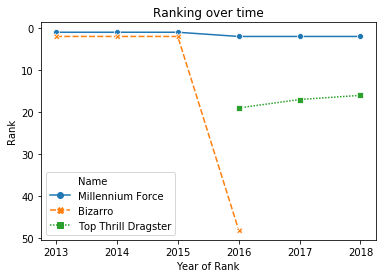

In [354]:
def rank_over_time(names, df):
    coaster_df = df[df["Name"].isin(names)].sort_values("Year of Rank")
    ax = sns.lineplot(data=coaster_df, x="Year of Rank", y="Rank", hue = "Name", style = "Name", markers = True)
    plt.gca().invert_yaxis()
    plt.title("Ranking over time")
    plt.show()
    
rank_over_time(["Millennium Force", "Top Thrill Dragster", "Bizarro"], steel_awards)

Say we don't know which rides were the top rides over time, but we'd like to see how the top 5 ranking changed. We could create a function to plot these!

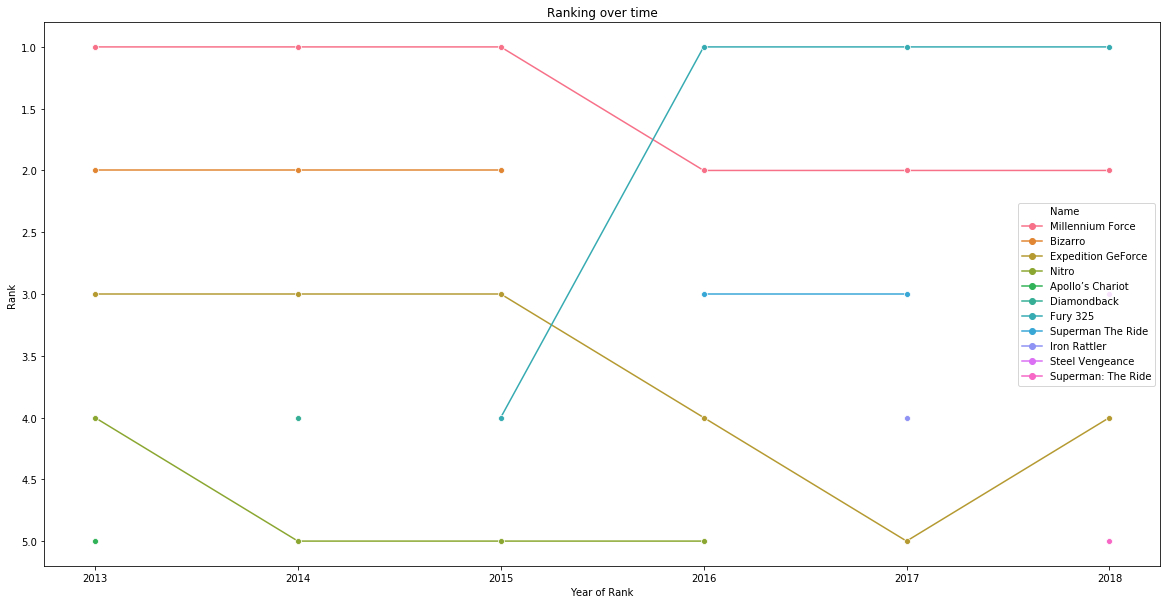

In [389]:
def top_n(n, df):
    coaster_df = df[df["Rank"] <= n]
    plt.figure(figsize = (20,10))
    n = len(pd.unique(coaster_df['Name']))
    sns.lineplot(data=coaster_df, x="Year of Rank", y="Rank", hue = "Name", style="Name", dashes=False, markers = ['o']*n)
    plt.gca().invert_yaxis()
    plt.title("Ranking over time")
    plt.show()

top_n(5, steel_awards)

The csv file `roller_coasters.csv` contains data from the site [Captain Coaster](https://captaincoaster.com/en/) which collects all sorts of data for roller coasters.

In [392]:
coaster_df = pd.read_csv("roller_coasters.csv")
coaster_df.head(10)

,name,material_type,seating_type,speed,height,length,num_inversions,manufacturer,park,status
0,Goudurix,Steel,Sit Down,75.0,37.0,950.0,7.0,Vekoma,Parc Asterix,status.operating
1,Dream catcher,Steel,Suspended,45.0,25.0,600.0,0.0,Vekoma,Bobbejaanland,status.operating
2,Alucinakis,Steel,Sit Down,30.0,8.0,250.0,0.0,Zamperla,Terra Mítica,status.operating
3,Anaconda,Wooden,Sit Down,85.0,35.0,1200.0,0.0,William J. Cobb,Walygator Parc,status.operating
4,Azteka,Steel,Sit Down,55.0,17.0,500.0,0.0,Soquet,Le Pal,status.operating
5,Bat Coaster,Steel,Inverted,70.0,20.0,400.0,2.0,Pinfari,Nigloland,status.relocated
6,Batman : Arkham Asylum,Steel,Inverted,80.0,32.0,823.0,5.0,B&M,Parque Warner Madrid,status.operating
7,Big Thunder Mountain,Steel,Sit Down,60.0,22.0,1500.0,0.0,Vekoma,Disneyland Park,status.operating
8,EqWalizer,Steel,Sit Down,76.0,36.0,285.0,3.0,Vekoma,Walibi Rhône Alpes,status.operating
9,Calamity Mine,Steel,Sit Down,48.0,14.0,785.0,0.0,Vekoma,Walibi Belgium,status.operating


Say you're going to a particular park and want to know which roller coaster have loops and if they do, how many times your feet will be abover your head. This function could be useful to you!

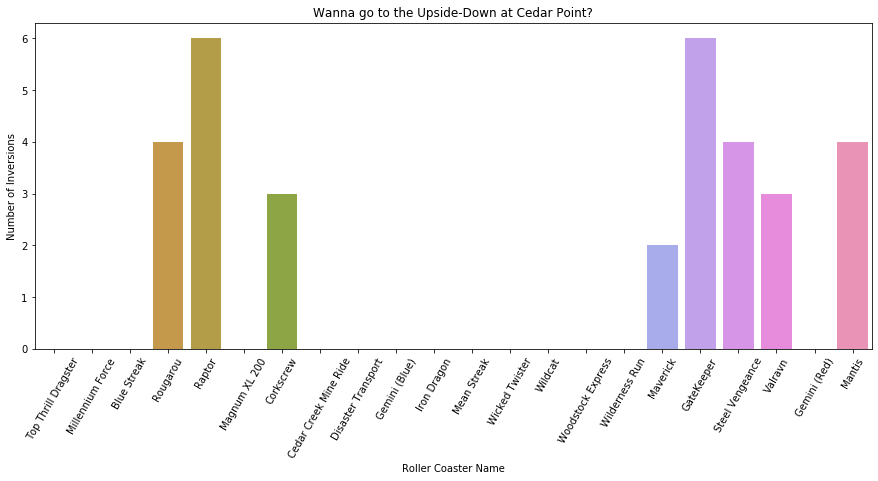

In [408]:
def loop_d_loop(df, park):
    loops = df[df["park"] == park]
    plt.figure(figsize = (15,6))
    sns.barplot(data = loops, x="name", y="num_inversions")
    plt.xticks(rotation=60)
    plt.xlabel("Roller Coaster Name")
    plt.ylabel("Number of Inversions")
    plt.title("Wanna go to the Upside-Down at " + park + "?")
    plt.show()
loop_d_loop(coaster_df, "Cedar Point")